In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [10]:
def calculate_separated_tems_transfer_func(freqs, l1, sym_fact, d):
    global term_values

    term_values = {}

    Rm = 1/0.333 # pS/µm2 = S/m2
    Cm = 0.01    # pF/µm2 = F/m2
    tau = Rm * Cm
    Ri = 1.5     # Mohm*µm = ohm*m

    gm = 2.09 * 1e-6  # pS/µm --> S/m
    ri = 0.477 * 1e12 # MOhm/µm --> Ohm/m
    lam = 1 / np.sqrt(gm * ri)


    for l in l1:
        L1 = l / lam

        for sym in sym_fact:
            # if l == 0.8e-3 and sym == 0.7:
            #     ds_values = np.linspace(10e-6, 20e-6, 2)
            # else:
            #     ds_values = np.linspace(20e-6, 20e-6, 1)
            ds_values = np.linspace(20e-6, 20e-6, 1)

            for ds in ds_values:
                L2 = sym * L1 

                # cell_name = f"l_1={l*1e6},l_2={sym}*l_1,d_s={ds*1e6}"
                cell_name = f"l_1={l*1e6},l_2={sym}*l_1"
                term_values[cell_name] = {'freqs': [], 'cosh_term': [], 'numerator':[], 'tanh_term': [], 'soma_term':[], 'denominator': [], 'transfer':[]}

                for f in freqs:
                    omega = 2 * np.pi * f
                    W = tau * omega

                    q = np.sqrt(1 + 1j * W)

                    cosh1 = 1 / np.cosh(q * L1)
                    cosh2 = 1 / np.cosh(q * L2)

                    cosh_term = (cosh1 - cosh2)
                    numerator = Rm/4*Ri * d**2 * cosh_term

                    term_values[cell_name]['freqs'].append(f)
                    term_values[cell_name]['cosh_term'].append(np.abs(cosh_term))
                    term_values[cell_name]['numerator'].append(np.abs(numerator))

                    tanh1 = np.tanh(q * L1)
                    tanh2 = np.tanh(q * L2)

                    soma_term = (ds**2*q**2)
                    tanh_term = np.sqrt(Rm/4*Ri * d**3)*q * (tanh1 + tanh2)

                    denominator = soma_term + tanh_term

                    term_values[cell_name]['tanh_term'].append(np.abs(tanh_term))
                    term_values[cell_name]['soma_term'].append(np.abs(soma_term))
                    term_values[cell_name]['denominator'].append(np.abs(denominator))

                    tot = np.abs(numerator/denominator)

                    term_values[cell_name]['transfer'].append(tot)

In [11]:
# Standard necessary values 
f = np.linspace(0, 1000, 500)
Rm = 1/0.333 #pS/µm2 = S/m2
Cm = 0.01   # pF/µm2 = F/m2

tau = Rm*Cm
omega = 2 * np.pi * f
W = tau * omega

q = np.sqrt(1 + 1j*W)


d = 2e-6
#ds = 20e-6
l1 = np.linspace(0.2e-3, 0.8e-3, 2)
sym_fact = np.linspace(0.3, 0.7, 2)
#ds_values = np.linspace(10e-6, 20e-6, 2)

term_values = {}
calculate_separated_tems_transfer_func(f, l1, sym_fact, d)

l_1=200.0,l_2=0.3*l_1
l_1=200.0,l_2=0.7*l_1
l_1=800.0,l_2=0.3*l_1
l_1=800.0,l_2=0.7*l_1


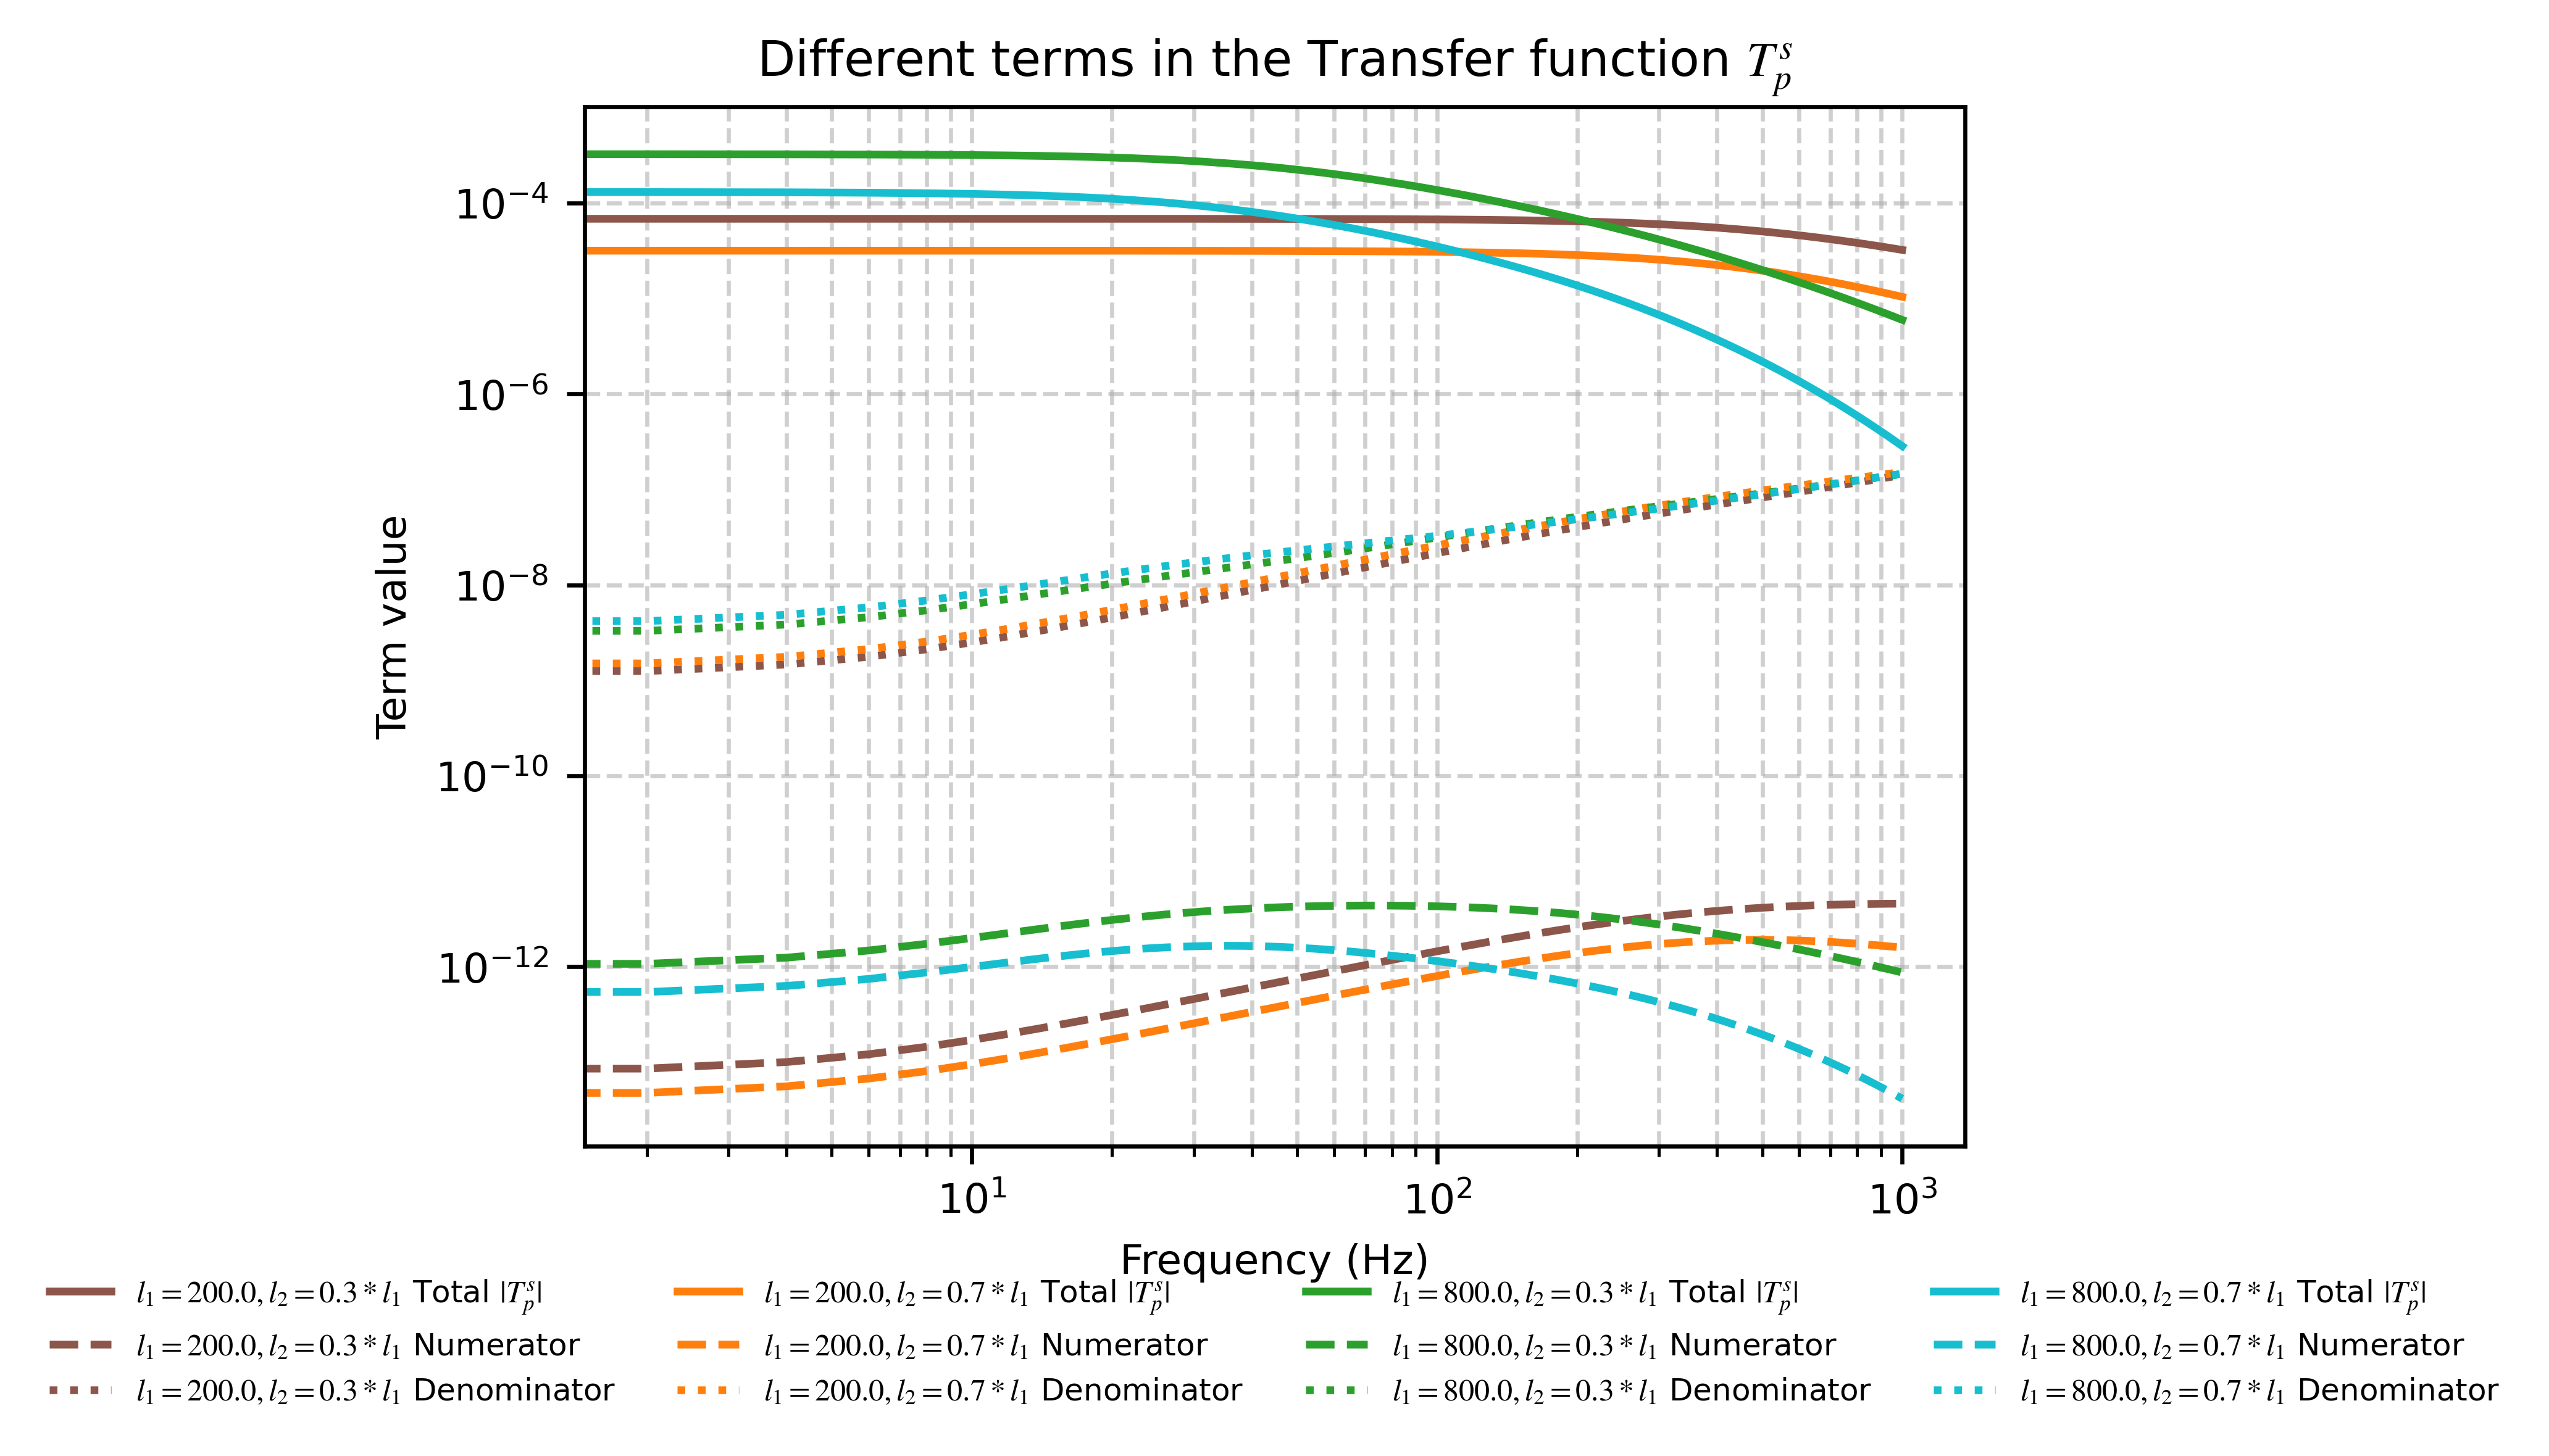

In [12]:
plt.figure(figsize=(6, 4))
plt.rcParams['mathtext.fontset'] = 'stix'

i = 0

for cell_name, values in term_values.items():
    print(cell_name)
    freqs = values['freqs']
    transfer = values['transfer']
    numerator = values['numerator']
    denominator = values['denominator']
    soma_term = values['soma_term']
    tanh_term = values['tanh_term']

    if i == 0:
        color = 'tab:brown'
    elif i == 1:
        color = 'tab:orange'
    elif i == 2:
        color = 'tab:green'
    elif i == 3: 
        color = 'tab:cyan'
    elif i == 4:
        color = 'tab:red'
    elif i == 5:
        color = 'tab:pink'
    elif i == 6:
        color = 'tab:blue'
    elif i == 7:
        color = 'grey'

    if cell_name == 'l_1=800.0,l_2=0.7*l_1,d_s=10.0':
        plt.loglog(freqs, denominator, label = f'${cell_name}$ Denominator', linestyle = ':', color = color)
    else:
        plt.loglog(freqs, transfer, label = f'${cell_name}$ Total $|T_p^s|$', linestyle = '-', color = color)
        plt.loglog(freqs, numerator, label = f'${cell_name}$ Numerator', linestyle = '--', color = color)
        plt.loglog(freqs, denominator, label = f'${cell_name}$ Denominator', linestyle = ':', color = color)
    #plt.loglog(freqs, soma_term, label = f'{cell_name}_soma_term', linestyle = '-', color = color)
    #plt.loglog(freqs, tanh_term, label = f'{cell_name}_tanh_term', linestyle = '--', color = color)

    i += 1


plt.xlabel("Frequency (Hz)")
plt.ylabel("Term value")
plt.title("Different terms in the Transfer function $T_p^s$")
plt.grid(True, which="both", ls="--", alpha=0.6)

plt.legend(
    fontsize=6,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    frameon=False
)

plt.tight_layout()
plt.show()